In [24]:
#下载数据
import requests
import urllib.request
url="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
urllib.request.urlretrieve(url, "a9a")   #下载数据集

#加载数据：使用sklearn库的load_svmlight_file函数读取数据
from sklearn.datasets import load_svmlight_file
import numpy as np

X_train,y_train=load_svmlight_file("a9a",n_features=123)  #加载训练集数据
X_train=X_train.toarray()    #很重要！！！X稀疏矩阵数据格式需转换成nd.array形式
y_train=np.reshape(y_train,(y_train.shape[0],1))  

X_test,y_test=load_svmlight_file("a9a.t",n_features=123) #加载测试集数据
X_test=X_test.toarray()    #很重要！！！X稀疏矩阵数据格式需转换成nd.array形式
y_test=np.reshape(y_test,(y_test.shape[0],1))  

print(X_train.shape,type(X_train))
print(y_train.shape,type(y_train))
print(X_test.shape,type(X_test))
print(y_test.shape,type(y_test))

(32561, 123) <class 'numpy.ndarray'>
(32561, 1) <class 'numpy.ndarray'>
(16281, 123) <class 'numpy.ndarray'>
(16281, 1) <class 'numpy.ndarray'>


In [25]:
#SVM及随机梯度下降
import random

def J(W,X_test,y_test,C):     #逻辑回归,计算单个样本的损失函数
    h=1 - np.multiply(y_test,np.dot(X_test,W))
    h=np.where(h>=0,h,0)
    loss=1/2*np.dot(W.T,W)+np.average(h)
    return loss[0][0]

def GD(X_train,y_train,W,lr,C,batch_size):
    m,dim=np.shape(X_train)
    grad=np.zeros([dim,1])
    for i in range(batch_size):   
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降       
        y = y_train[index][0]         # y其实就是label
        X = X_train[index]            #X表示一个样本数据
        h=1 - np.multiply(y,np.dot(W.T,X.reshape(dim,1)))
        if h<0: 
            grad+=W
        else:        
            grad+=W-C*(np.dot(y.reshape(1,1),X.reshape(1,dim)).T)
    grad=grad/batch_size
    W=W-lr*grad
    #print(W.reshape(1,dim))
    return W

def NAG(X_train,y_train,W,gama,lr,C,batch_size):
    m,dim=np.shape(X_train)
    V=np.zeros([dim,1])
    grad=np.zeros([dim,1])
    for i in range(batch_size):
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降       
        y = y_train[index][0]         # y其实就是label
        X = X_train[index]            #X表示一个样本数据
        h=1 - np.multiply(y,np.dot(W.T,X.reshape(dim,1)))
        if h<0: 
            grad+=W    
        else:        
            grad+=W-C*(np.dot(y.reshape(1,1),X.reshape(1,dim)).T)
    grad=grad/batch_size
    V=gama*V+lr*grad 
    W=W-V
    #print(W.reshape(1,dim))
    return W

def RMSProp(X_train,y_train,W,gama,lr,E,C,batch_size):
    m,dim=np.shape(X_train)
    G=np.zeros([dim,1])
    grad=np.zeros([dim,1])
    for i in range(batch_size):
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降          
        y = y_train[index][0]         # y其实就是label
        X = X_train[index]            #X表示一个样本数据
        h=1 - np.multiply(y,np.dot(W.T,X.reshape(dim,1)))
        if h<0:      
            grad+=W      
        else:  
            grad+=W-C*(np.dot(y.reshape(1,1),X.reshape(1,dim)).T)
    grad=grad/batch_size
    G=gama*G+(1-gama)*np.multiply(grad,grad)         
    W=W-np.multiply(lr/(np.sqrt(G+E)),grad)
    return W


def AdaDelta(X_train,y_train,W,gama,E,C,batch_size):
    m,dim=np.shape(X_train)
    G=np.zeros([dim,1])
    T=np.zeros([dim,1])
    grad=np.zeros([dim,1])
    for i in range(batch_size):
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降          
        y = y_train[index][0]         # y其实就是label
        X = X_train[index]            #X表示一个样本数据
        h=1 - np.multiply(y,np.dot(W.T,X.reshape(dim,1)))
        if h<0:      
            grad+=W     
        else:
            grad+=W-C*(np.dot(y.reshape(1,1),X.reshape(1,dim)).T)
    grad=grad/batch_size
    G=gama*G+(1-gama)*np.multiply(grad,grad)
    delt_grad=np.multiply(-1*np.sqrt(T+E)/(np.sqrt(G+E)),grad)
    T=gama*T+(1-gama)*np.multiply(delt_grad,delt_grad)   
    W=W+delt_grad
    return W

def Adam(X_train,y_train,W,gama,lr,E,beta,C,batch_size):
    m,dim=np.shape(X_train)
    M=np.zeros([dim,1])
    G=np.zeros([dim,1])
    grad=np.zeros([dim,1])
    for i in range(batch_size):
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降         
        y = y_train[index][0]         # y其实就是label
        X = X_train[index]            #X表示一个样本数据
        h=1 - np.multiply(y,np.dot(W.T,X.reshape(dim,1)))
        if h<0:      
            grad+=W     
        else:  
            grad+=W-C*(np.dot(y.reshape(1,1),X.reshape(1,dim)).T)
    grad=grad/batch_size
    M=beta*M+(1-beta)*grad
    G=gama*G+(1-gama)*np.multiply(grad,grad)
    alpha=lr*np.sqrt(1-gama)/(1-beta)
    W=W-alpha*M/(np.sqrt(G+E))
    return W


In [ ]:
def predict(X_test,y_test,W):   #预测正确率
    m,dim=np.shape(X_test)
    num_correct = 0
    yp=np.dot(X_test,W)
    for i in range(0,m):
        predict=-1
        target=y_test[i][0]
        if(yp[i][0]>0):
            predict=1
        if(predict*target)>0:
            num_correct+=1   
    return num_correct*1.0/m 

In [26]:
#设置参数
epochs=1000         #迭代次数  
batch_size=1000
C=0.9 
m,dim=np.shape(X_train)

losses_GD=[]
W = np.ones([dim,1])     #初始化W全为1或的n*1向量
lr=0.01
for i in range(0,epochs): 
    #print(W.reshape(1,dim))
    W=GD(X_train,y_train,W,lr,C,batch_size)
    #print(W.reshape(1,dim))
    loss=J(W,X_test,y_test,C)
    losses_GD.append(loss)
    #print("epochs:",i,"\t loss: ", loss)

    
losses_NAG=[]
W = np.ones([dim,1])     #初始化W全为1或的n*1向量
gama=0.9
lr=0.01
for i in range(0,epochs): 
    #print(W.reshape(1,dim))
    W=NAG(X_train,y_train,W,gama,lr,C,batch_size)
    #print(W.reshape(1,dim))
    loss=J(W,X_test,y_test,C)
    losses_NAG.append(loss)
    #print("epochs:",i,"\t loss: ", loss)
        

losses_RMSProp=[]
W = np.ones([dim,1])     #初始化W全为1或的n*1向量
gama=0.9
lr=0.01
E=1e-6
for i in range(0,epochs):       
    W=RMSProp(X_train,y_train,W,gama,lr,E,C,batch_size)
    loss=J(W,X_test,y_test,C)
    losses_RMSProp.append(loss)
    #print("epochs:",i,"\t loss: ", loss)
        
        
losses_AdaDelta=[]
W = np.ones([dim,1])     #初始化W全为1或的n*1向量
gama=0.96
E=1e-6
for i in range(0,epochs):       
    W=AdaDelta(X_train,y_train,W,gama,E,C,batch_size)
    loss=J(W,X_test,y_test,C)
    losses_AdaDelta.append(loss)
        
        
losses_Adam=[]
W = np.ones([dim,1])     #初始化W全为1或的n*1向量
gama=0.999
lr=0.01
E=1e-6
deta=0.9
for i in range(0,epochs):       
    W=Adam(X_train,y_train,W,gama,lr,E,deta,C,batch_size)
    loss=J(W,X_test,y_test,C)
    losses_Adam.append(loss)
    #print("epochs:",i,"\t loss: ", loss)

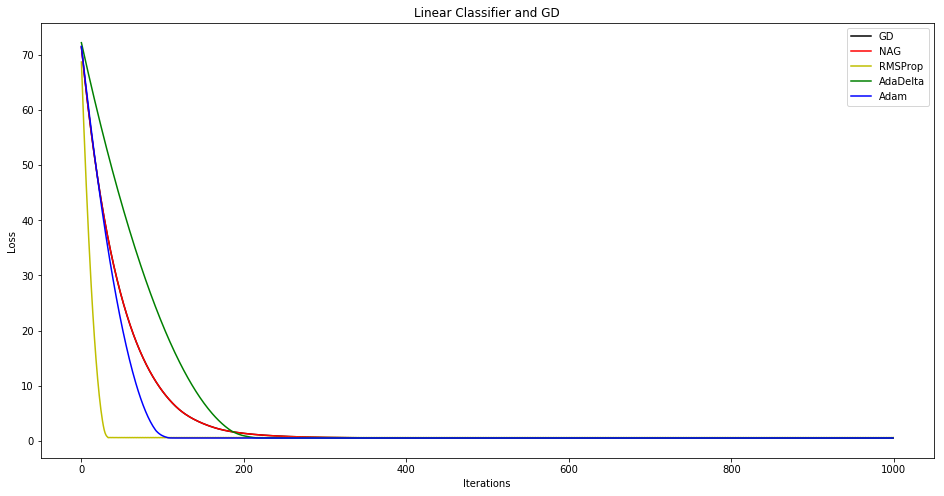

In [27]:
#画出图形
%matplotlib inline
import matplotlib.pyplot as plt

#loss figure
plt.figure(figsize=(16,8))
plt.plot(losses_GD,color='black',label='GD')
plt.plot(losses_NAG,color='r',label='NAG')
plt.plot(losses_RMSProp,color='y',label='RMSProp')
plt.plot(losses_AdaDelta,color='g',label='AdaDelta')
plt.plot(losses_Adam,color='b',label='Adam')
plt.legend(loc='upper right')
plt.title("Linear Classifier and GD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
